In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os
import gc
from pathlib import Path

from pure_pursuit import *
import tensorflow as tf

import matplotlib.pyplot as plt

2023-11-28 22:30:46.715147: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 22:30:47.176324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 22:30:48.271099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
MODEL_SAVE_DIR = Path("PI_model")
if not MODEL_SAVE_DIR.exists():
    os.makedirs(MODEL_SAVE_DIR.as_posix())

### Loading data files

In [1]:
train_files = []
val_files = []

path = Path("../../torcs_SL/data_all/data")
tracks = os.listdir(path.as_posix())

train_tracks = ['g-track-1', 'g-track-2', 'g-track-3', 'g-track-4', 'spring']
test_tracks = ['e-track-3', 'alpine-2', 'corkscrew', 'wheel-2']

random_tracks = np.random.choice(tracks, len(tracks), replace=False)
random_tracks = [x for x in random_tracks if x[:4] != 'dirt' and x[:3] != 'mix' and x not in test_tracks and x not in train_tracks]

val_tracks = random_tracks[:3]
    

track_files = list(path.glob("**/*.csv"))


train_track_files = [x for x in track_files if x.parts[-2] in train_tracks]
val_track_files = [x for x in track_files if x.parts[-2] in val_tracks]
train_track_files, val_track_files

NameError: name 'Path' is not defined

### Train-Test Split

In [5]:
training_data = pd.DataFrame()
validation_data = pd.DataFrame()
split_ratio = 0.8

for fi in track_files[:int(split_ratio * len(track_files))]:
    training_data = pd.concat([training_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in track_files[int(split_ratio * len(track_files)):]:
    validation_data = pd.concat([validation_data, pd.read_csv(fi)]).reset_index(drop=True)

In [6]:
print (training_data.shape)
print (validation_data.shape)

(519621, 79)
(138039, 79)


In [7]:
training_data.columns.values

array(['Angle', ' CurrentLapTime', ' Damage', ' DistanceFromStart',
       ' DistanceCovered', ' FuelLevel', ' Gear', ' LastLapTime',
       ' Opponent_1', 'Opponent_2', 'Opponent_3', 'Opponent_4',
       'Opponent_5', 'Opponent_6', 'Opponent_7', 'Opponent_8',
       'Opponent_9', 'Opponent_10', 'Opponent_11', 'Opponent_12',
       'Opponent_13', 'Opponent_14', 'Opponent_15', 'Opponent_16',
       'Opponent_17', 'Opponent_18', 'Opponent_19', 'Opponent_20',
       'Opponent_21', 'Opponent_22', 'Opponent_23', 'Opponent_24',
       'Opponent_25', 'Opponent_26', 'Opponent_27', 'Opponent_28',
       'Opponent_29', 'Opponent_30', 'Opponent_31', 'Opponent_32',
       'Opponent_33', 'Opponent_34', 'Opponent_35', 'Opponent_36',
       'RacePosition', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
       ' Track_1', 'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6',
       'Track_7', 'Track_8', 'Track_9', 'Track_10', 'Track_11',
       'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16',
  

In [8]:
del training_data['Gear']
del validation_data['Gear']
del training_data[' CurrentLapTime']
del validation_data[' CurrentLapTime']
del training_data[' LastLapTime']
del validation_data[' LastLapTime']
del training_data[' Damage']
del validation_data[' Damage']
del training_data[' FuelLevel']
del validation_data[' FuelLevel']

del training_data[' DistanceFromStart']
del validation_data[' DistanceFromStart']

for col in [c for c in training_data.columns if c.strip()[:3] == "Opp"]:
    del training_data[col]
    del validation_data[col]

In [9]:
print (training_data.shape)
print (validation_data.shape)

(519621, 37)
(138039, 37)


In [10]:
training_data.columns

Index(['Angle', ' DistanceCovered', ' Gear', 'RacePosition', ' RPM', ' SpeedX',
       ' SpeedY', ' SpeedZ', ' Track_1', 'Track_2', 'Track_3', 'Track_4',
       'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 'Track_10',
       'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16',
       'Track_17', 'Track_18', 'Track_19', 'TrackPosition',
       ' WheelSpinVelocity_1', 'WheelSpinVelocity_2', 'WheelSpinVelocity_3',
       'WheelSpinVelocity_4', 'Z', ' Acceleration', 'Braking', 'Clutch',
       'Steering'],
      dtype='object')

## PI Model Training

In [11]:
X_train=training_data.loc[:,[' Track_1',
       'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7',
       'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13',
       'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 
        'TrackPosition', 'Angle', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
        ' WheelSpinVelocity_1', 'WheelSpinVelocity_2',
       'WheelSpinVelocity_3', 'WheelSpinVelocity_4']]

Y_train=training_data.loc[:,'Steering']
X_val=validation_data.loc[:,[' Track_1',
       'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7',
       'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13',
       'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 
        'TrackPosition', 'Angle', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
        ' WheelSpinVelocity_1', 'WheelSpinVelocity_2',
       'WheelSpinVelocity_3', 'WheelSpinVelocity_4']]
Y_val=validation_data.loc[:,'Steering']

In [12]:
print (X_train.shape)
print (Y_train.shape)
print (X_val.shape)
print (Y_val.shape)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.fit_transform(X_val)
Y_train=Y_train.values
Y_val=Y_val.values
print (X_train.shape)
print (Y_train.shape)
print (X_val.shape)
print (Y_val.shape)

(519621, 29)
(519621,)
(138039, 29)
(138039,)
(519621, 29)
(519621,)
(138039, 29)
(138039,)


### Save these means and stds for test time

In [13]:
with open(MODEL_SAVE_DIR.joinpath("scaler.pickle").as_posix(), "wb") as fp:
    pickle.dump(scaler, fp)

In [14]:
scaler.mean_

array([ 6.24377390e+00,  6.46039231e+00,  8.14328169e+00,  1.09305702e+01,
        2.37074753e+01,  3.33264104e+01,  4.76698874e+01,  7.38746509e+01,
        9.28187577e+01,  9.24490493e+01,  9.12028298e+01,  7.20530952e+01,
        5.44666274e+01,  2.88263642e+01,  2.26762674e+01,  1.46944497e+01,
        1.13330443e+01,  9.10589650e+00,  8.78586323e+00,  1.68987330e-01,
       -9.64581253e-03,  8.07197982e+03,  1.71176814e+02, -1.53788030e+00,
        5.34090456e-03,  1.42935327e+02,  1.42018317e+02,  1.47526819e+02,
        1.47012780e+02])

In [15]:
scaler.scale_

array([3.05584035e+00, 3.17758415e+00, 4.00280612e+00, 5.35350871e+00,
       2.48159830e+01, 2.68059923e+01, 2.61177442e+01, 3.59693188e+01,
       5.81569880e+01, 5.73160590e+01, 5.62468062e+01, 3.97075969e+01,
       3.54849164e+01, 9.74499472e+00, 6.17169700e+00, 4.73765979e+00,
       3.87665283e+00, 3.18931114e+00, 3.06420208e+00, 4.07250572e-01,
       6.38364431e-02, 8.51465817e+02, 4.14759520e+01, 3.52994342e+00,
       4.47055383e+00, 3.46408745e+01, 3.56037515e+01, 3.47100209e+01,
       3.52446343e+01])

In [16]:
np.save(MODEL_SAVE_DIR.joinpath("means.npy"), scaler.mean_)
np.save(MODEL_SAVE_DIR.joinpath("stds.npy"), scaler.scale_)

In [17]:
@tf.function
def get_max_dist(track_dists):
    return tf.reduce_max(track_dists, axis=1)

@tf.function
def get_max_dist_idx(track_dists):
    mask = track_dists[:, 9] != 200
    mask = tf.cast(mask, tf.int32)
    indices = tf.math.argmax(track_dists, output_type=tf.int32, axis=1)
    arr1 = indices * mask
    additional = tf.cast(track_dists[:, 9] == 200, tf.int32) * 9
    result = arr1 + additional
    
    return result

@tf.function
def compute_target_angle(track_dists):

    max_track_dist_idx = get_max_dist_idx(track_dists)

    max_dist_angle = max_track_dist_idx * 10 - 90
    return tf.cast(max_dist_angle, tf.float32) * RAD_PER_DEG

@tf.function
def compute_target_angle_2(angle_probs):

    max_track_dist_idx = tf.math.argmax(angle_probs, output_type=tf.int32, axis=1)

    max_dist_angle = max_track_dist_idx * 10 - 90
    return tf.cast(max_dist_angle, tf.float32) * RAD_PER_DEG

In [18]:
@tf.function
def is_off_track(trackPos, angle):
    return tf.abs(trackPos) > 1.0 and tf.abs(angle) > PI_HALF

In [19]:
@tf.function
def compute_steering(data):
    
    track, lookahead = data
    track = (track * scaler.scale_[:19]) + scaler.mean_[:19]
    target_angle = compute_target_angle(track)  # radians


    raw_steering_angle_rad = -tf.math.atan(
        (PURE_PURSUIT_2L * tf.math.sin(target_angle)) / (lookahead + 1e-7))

    raw_steering_angle_deg = raw_steering_angle_rad * DEG_PER_RAD

    normalized_steering_angle = tf.clip_by_value(raw_steering_angle_deg / MAX_STEERING_ANGLE_DEG, -1.0, 1.0)

#     if EDGE_AVOIDANCE_ENABLED and not is_off_track(trackPos, angle):
#         edge_steering_correction = 0.

#         if trackPos > EDGE_MAX_TRACK_POS and angle < 0.005:  # too far left
#             edge_steering_correction = -EDGE_STEERING_INPUT
#         elif trackPos < -EDGE_MAX_TRACK_POS and track > -0.005:  # too far right
#             edge_steering_correction = EDGE_STEERING_INPUT

#         normalized_steering_angle += edge_steering_correction

    return normalized_steering_angle

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_delta=0.0001, min_lr=0)

In [25]:
learning_rate=1e-3

input_p = Input(shape=(X_train.shape[1],))
l_p = Dense(16, activation="relu",kernel_initializer='he_normal', name='dense_1')(input_p)
l_p = Dense(8, activation="relu",kernel_initializer='he_normal', name='dense_3')(l_p)
lookahead = Dense(1, activation="relu",kernel_initializer='he_normal', name='lookahead')(l_p)

out_p = Lambda(compute_steering, name='pp_based_steering')([input_p[:,0:19], lookahead[:,0]])
# out_p = Lambda(compute_steering, name='pp_based_steering')([input_p[:,-1], lookahead[:,0]])

model = tf.keras.Model(input_p, [out_p, lookahead])

model.compile(optimizer=Adam(learning_rate),loss='mean_absolute_error',metrics=['mae'],
             loss_weights=[1, 0])


In [31]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 29)]         0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 16)           480         ['input_3[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 8)            136         ['dense_1[0][0]']                
                                                                                                  
 lookahead (Dense)              (None, 1)            9           ['dense_3[0][0]']                
                                                                                            

In [26]:
stats = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=512,epochs=50,callbacks=[reduce_lr])

Epoch 1/50
1015/1015 [==============================] - 3s 2ms/step - loss: 0.1644 - pp_based_steering_loss: 0.1644 - lookahead_loss: 45.2492 - pp_based_steering_mae: 0.1644 - lookahead_mae: 45.2492 - val_loss: 0.0326 - val_pp_based_steering_loss: 0.0326 - val_lookahead_loss: 71.5623 - val_pp_based_steering_mae: 0.0326 - val_lookahead_mae: 71.5623 - lr: 0.0010
Epoch 2/50
1015/1015 [==============================] - 2s 2ms/step - loss: 0.0293 - pp_based_steering_loss: 0.0293 - lookahead_loss: 84.7319 - pp_based_steering_mae: 0.0293 - lookahead_mae: 84.7319 - val_loss: 0.0221 - val_pp_based_steering_loss: 0.0221 - val_lookahead_loss: 95.3452 - val_pp_based_steering_mae: 0.0221 - val_lookahead_mae: 95.3452 - lr: 0.0010
Epoch 3/50
1015/1015 [==============================] - 2s 2ms/step - loss: 0.0200 - pp_based_steering_loss: 0.0200 - lookahead_loss: 107.7197 - pp_based_steering_mae: 0.0200 - lookahead_mae: 107.7197 - val_loss: 0.0170 - val_pp_based_steering_loss: 0.0170 - val_lookahead_l

1015/1015 [==============================] - 2s 2ms/step - loss: 0.0100 - pp_based_steering_loss: 0.0100 - lookahead_loss: 545.0057 - pp_based_steering_mae: 0.0100 - lookahead_mae: 545.0057 - val_loss: 0.0101 - val_pp_based_steering_loss: 0.0101 - val_lookahead_loss: 545.2556 - val_pp_based_steering_mae: 0.0101 - val_lookahead_mae: 545.2556 - lr: 1.0000e-04
Epoch 46/50
1015/1015 [==============================] - 2s 2ms/step - loss: 0.0100 - pp_based_steering_loss: 0.0100 - lookahead_loss: 545.5945 - pp_based_steering_mae: 0.0100 - lookahead_mae: 545.5945 - val_loss: 0.0101 - val_pp_based_steering_loss: 0.0101 - val_lookahead_loss: 545.3021 - val_pp_based_steering_mae: 0.0101 - val_lookahead_mae: 545.3021 - lr: 1.0000e-05
Epoch 47/50
1015/1015 [==============================] - 2s 2ms/step - loss: 0.0100 - pp_based_steering_loss: 0.0100 - lookahead_loss: 545.6641 - pp_based_steering_mae: 0.0100 - lookahead_mae: 545.6641 - val_loss: 0.0101 - val_pp_based_steering_loss: 0.0101 - val_look

In [29]:
model.save(MODEL_SAVE_DIR.joinpath('model.h5'))

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


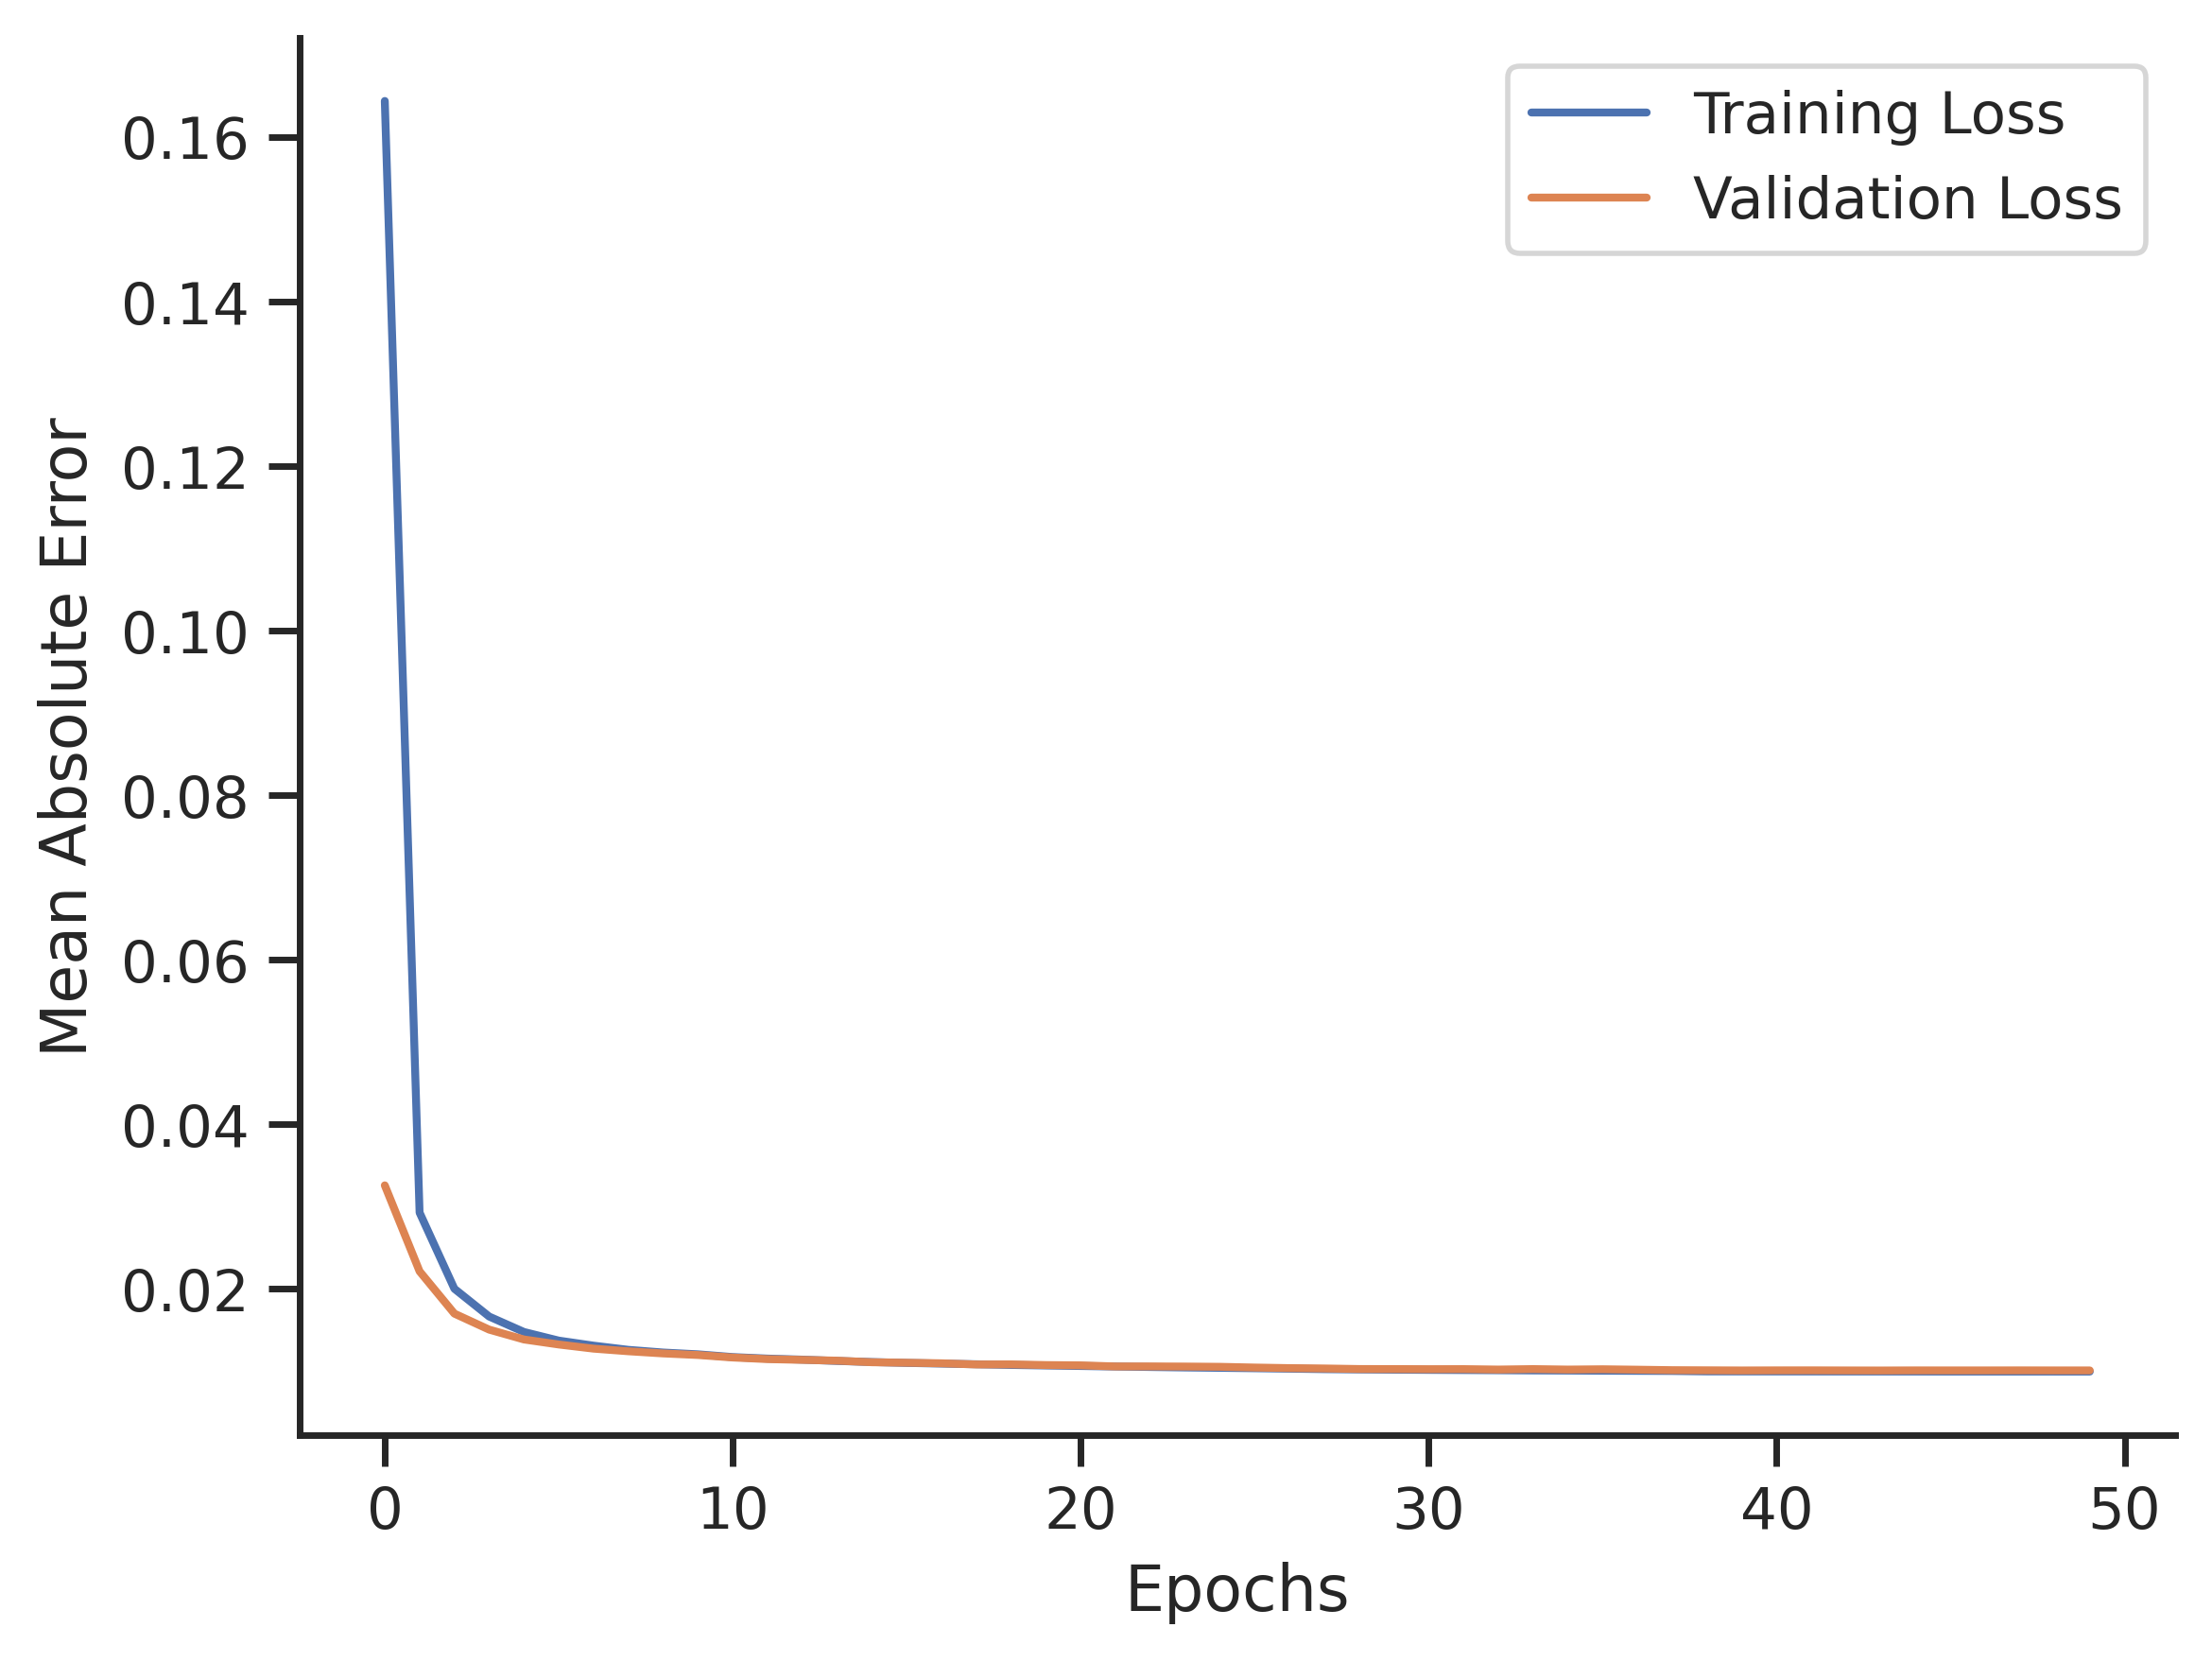

In [30]:
fig, ax = plt.subplots(dpi=400)
ax.plot(stats.history['loss'])
ax.plot(stats.history['val_loss'])
ax.legend(['Training Loss', 'Validation Loss'])
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Error")

fig.savefig("pi_loss.png")

In [28]:
preds = model.predict(X_val)


4314/4314 [==============================] - 2s 560us/step


(array([84519.,  5880.,  5245.,  9264.,  4605.,  2032.,  1765.,  7764.,
        16593.,   372.]),
 array([  33.56467438,  325.8132019 ,  618.06176758,  910.31030273,
        1202.55883789, 1494.80737305, 1787.0559082 , 2079.30444336,
        2371.55297852, 2663.80151367, 2956.05004883]),
 <BarContainer object of 10 artists>)

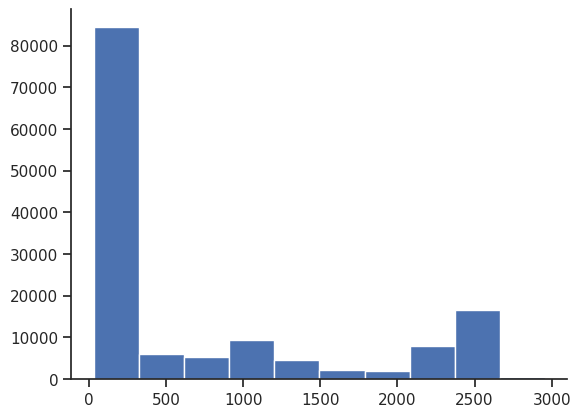

In [30]:
plt.hist(preds[1])

In [33]:
model = load_model("PI_model/model.h5", custom_objects={'compute_steering': compute_steering,
                                                               'compute_target_angle': compute_target_angle,
                                                               'get_max_dist_idx': get_max_dist_idx})

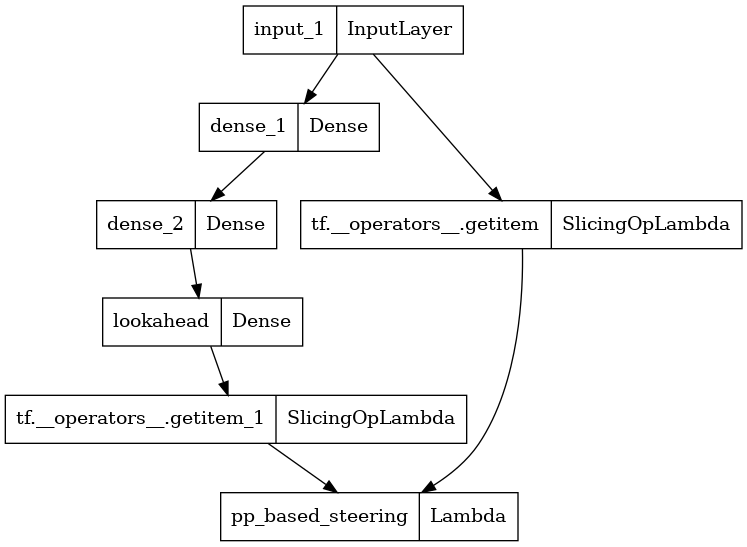

In [31]:
tf.keras.utils.plot_model(model)